In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
# ?? some of these I could probably remove
from __future__ import print_function
import os
import numpy as np
import random
# import string
import tensorflow as tf
import zipfile
from six.moves import range
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

In [2]:
# Define some useful functions
def normFtrs(npMtrx):
    # Normalize each feature to be zero mean, unit standard deviation
    nDim=npMtrx.shape
    ftrMns=np.zeros((1,nDim[1]))
    ftrSDs=np.zeros((1,nDim[1]))
    ftrMns[:1,:]=npMtrx.mean(axis=0)
    ftrSDs[:1,:]=npMtrx.std(axis=0)
    
    for a in range(nDim[1]):
        npMtrx[:,a:(a+1)]=(npMtrx[:,a:(a+1)]-ftrMns[0,a])/ftrSDs[0,a]
    
    return ftrMns, ftrSDs

In [3]:
# Load Lorenz data
# inFname='/Users/davidgroppe/PycharmProjects/GROPPE_TF/genSinWave.mat'
inFname='/Users/davidgroppe/ONGOING/RNN/ECHO_STATE/LORENZ/lorenzData.mat'
print('Loading: {}'.format(inFname))
matContents=sio.loadmat(inFname)
data=matContents['data']
nTpt=data.shape[0]
nDim=data.shape[1]
print('# of timepoints %d' % nTpt)
print('Pre-normalized data SDs')
print(data.std(axis=0))
# Normalize data to unit standard deviation and zero mean
ftrMns, ftrSDs=normFtrs(data)
print('Post-normalized data SDs')
print(data.std(axis=0))
print('Post-normalized data means')
print(data.mean(axis=0))


Loading: /Users/davidgroppe/ONGOING/RNN/ECHO_STATE/LORENZ/lorenzData.mat
# of timepoints 1000000
Pre-normalized data SDs
[ 0.15780923  0.18406343  0.16868617]
Post-normalized data SDs
[ 1.  1.  1.]
Post-normalized data means
[  1.63424829e-17   1.48361323e-17   2.23682406e-15]


In [4]:
nTpt=data.shape[0]
validSize = nTpt//10
totalTpts=data.shape[0]
validData = data[-validSize:,:]
trainData = data[:totalTpts-validSize,:]
trainSize = len(trainData)
print('Training nTpts: {}'.format(trainSize))
print('Validation nTpts: {}'.format(validSize))
print('Total nTpts: {}'.format(totalTpts))

Training nTpts: 900000
Validation nTpts: 100000
Total nTpts: 1000000


In [5]:
# Batch generating functions
batch_size=10 # Number of random contiguous chunks of data to return (10=Ng rule of thumb)
num_unrollings=20 # Number of consecutive time points in each chunk

class BatchGenerator(object):
  def __init__(self, dataPts, batch_size, num_unrollings):
    self._dataPts = dataPts
    self._nTpts = len(dataPts)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._nTpts // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, nDim), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, :] = self._dataPts[self._cursor[b],:]
      self._cursor[b] = (self._cursor[b] + 1) % self._nTpts #modulus makes sure you don't exceed length of 
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def batches2timeSeries(batches):
    """Convert a sequence of batches back into a time series representation."""
    nUnrollPlus1=len(batches)
    nBatches=batches[0].shape[0]
    s=[]
    for b in range(nBatches):
        s.append(np.zeros((nUnrollPlus1,nDim)))
    for b in range(nBatches):
        for c in range(nUnrollPlus1):
            s[b][c,:]=batches[c][b,:]
    return s
#   s = [''] * batches[0].shape[0]
#   for b in batches:
#     s = [''.join(x) for x in zip(s, characters(b))]
#   return s

train_batches = BatchGenerator(trainData, batch_size, num_unrollings)
valid_batches = BatchGenerator(validData, 1, 1)

# print(train_batches.next())
# print(train_batches.next())
# print(valid_batches.next())
# print(valid_batches.next())

In [14]:
bro=validData[0:1,:]
print(validData.shape)
print(bro.shape)
nValidTpt=validData.shape[0]
sis=validData[nValidTpt-1:nValidTpt,:]
sis.shape

(100000, 3)
(1, 3)


(1, 3)

In [6]:
#LSTM Model
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([nDim, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([nDim, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([nDim, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([nDim, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, nDim], -0.1, 0.1))
  b = tf.Variable(tf.zeros([nDim]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,nDim]))
  train_inputs = train_data[:num_unrollings]
  train_outputs = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    model_outputs = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b) # xw_plus_b does matrix multiplication plus bias; not sure what concat is for
    #loss = tf.reduce_mean(tf.pow(train_outputs-model_outputs, 2)) # use mean sqr error for cost function (mean is better than sum as it makes cost independent of batch size)
    loss = tf.reduce_mean(
        tf.pow(model_outputs-tf.concat(0, train_outputs), 2)) # use mean sqr error for cost function (mean is better than sum as it makes cost independent of batch size)
    
  # Add ops to save and restore all the variables.
  saver = tf.train.Saver()

  # Optimizer.
#   global_step = tf.Variable(0)
#   learning_rate = tf.train.exponential_decay(
#     1.0, global_step, 5000, 0.1, staircase=True)
#   learning_rate = tf.train.exponential_decay(
#     10.0, global_step, 5000, 0.1, staircase=True)
#   optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#   gradients, v = zip(*optimizer.compute_gradients(loss))
#   gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
#   optimizer = optimizer.apply_gradients(
#     zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = model_outputs
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, nDim])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.xw_plus_b(sample_output, w, b)


In [7]:
# Generate some data
nGen=80

with tf.Session(graph=graph) as sess:
  #Initialize all variables
  tf.initialize_all_variables().run()
  print('Initialized')
    
  # Restore variables from disk.
  saver.restore(sess,"/Users/davidgroppe/PycharmProjects/GROPPE_TF/lstmRegress.ckpt")
  #saver.restore(sess, "sinLstm.ckpt")
  #saver.restore(sess, "sinLstmWorks.ckpt")
  print("Model restored.")
    
  # Generate some data ??
  for _ in range(1):
    #feed = np.random.randn(1,nDim)
    feed = trainData[0:1,:]
    allGen = np.zeros((nGen,nDim))
    reset_sample_state.run()
    for genCt in range(nGen-1):
      prediction = sample_prediction.eval({sample_input: feed})
      allGen[genCt+1,:]=prediction
      feed=prediction

print('Done generating data.')

Initialized
Model restored.
Done generating data.


# of time points: 80


/Users/davidgroppe/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


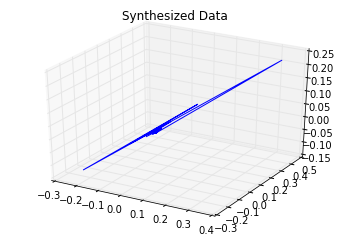

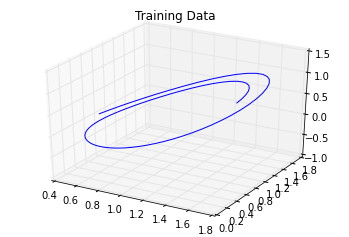

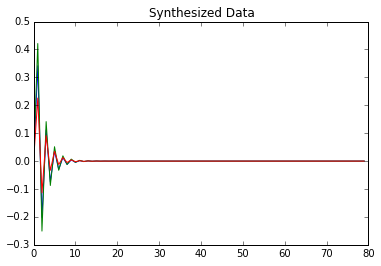

In [8]:
# Plot Data in 3d
print('# of time points: %d' % nGen)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(allGen[0:nGen,0],allGen[0:nGen,1],allGen[0:nGen,2],'-')
plt.title('Synthesized Data')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(trainData[0:nGen,0],trainData[0:nGen,1],trainData[0:nGen,2],'-')
plt.title('Training Data')

fig = plt.figure()
plt.plot(allGen[0:nGen,:],'-')
plt.title('Synthesized Data')

In [ ]:
# Plot generated data in 2D
fig = plt.figure()
showBatch=1
plt.plot(allGen,'-o')
# plt.plot(allGen[:1],'-or')
plt.title('allGen')